<a href="https://colab.research.google.com/github/Bruna-gc/NeuralNetworksResearch/blob/main/Stand_Dev_vs_Load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== Testing with N = 100 neurons ===
--> Testing with x = 50 trials for N = 100... <--
Time elapsed: 3.29 seconds
--> Testing with x = 55 trials for N = 100... <--
Time elapsed: 3.62 seconds
--> Testing with x = 60 trials for N = 100... <--
Time elapsed: 3.12 seconds
--> Testing with x = 65 trials for N = 100... <--
Time elapsed: 3.13 seconds
--> Testing with x = 70 trials for N = 100... <--
Time elapsed: 3.29 seconds

=== Testing with N = 150 neurons ===
--> Testing with x = 50 trials for N = 150... <--
Time elapsed: 4.51 seconds
--> Testing with x = 55 trials for N = 150... <--
Time elapsed: 4.26 seconds
--> Testing with x = 60 trials for N = 150... <--
Time elapsed: 4.83 seconds
--> Testing with x = 65 trials for N = 150... <--
Time elapsed: 5.54 seconds
--> Testing with x = 70 trials for N = 150... <--
Time elapsed: 5.75 seconds

=== Testing with N = 200 neurons ===
--> Testing with x = 50 trials for N = 200... <--
Time elapsed: 5.15 seconds
--> Testing with x = 55 trials for N = 

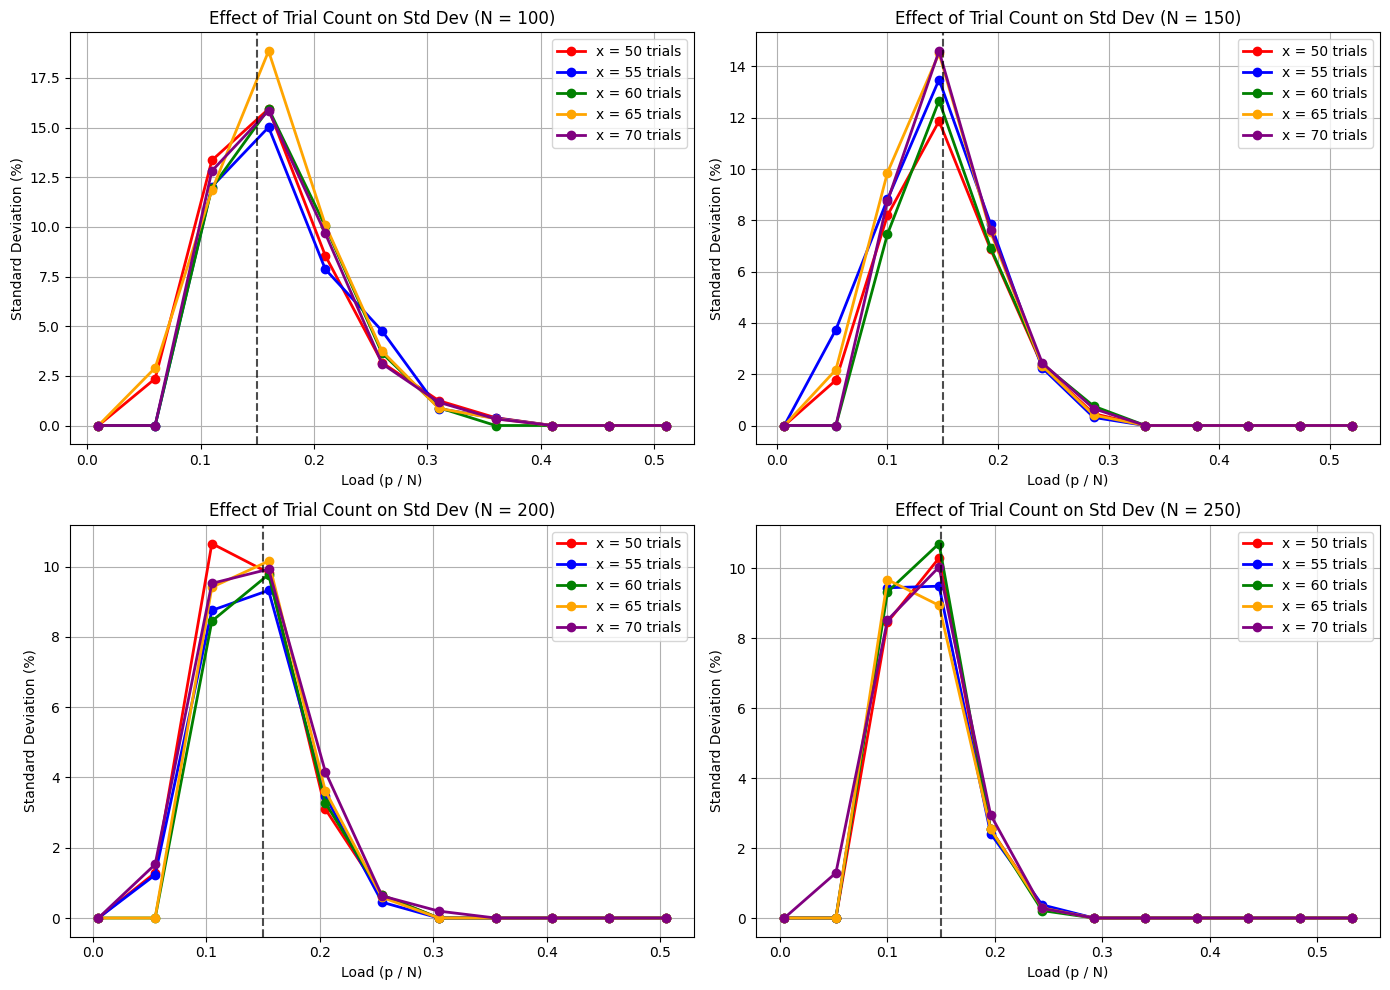


Creating comparison plot for x = 60 trials


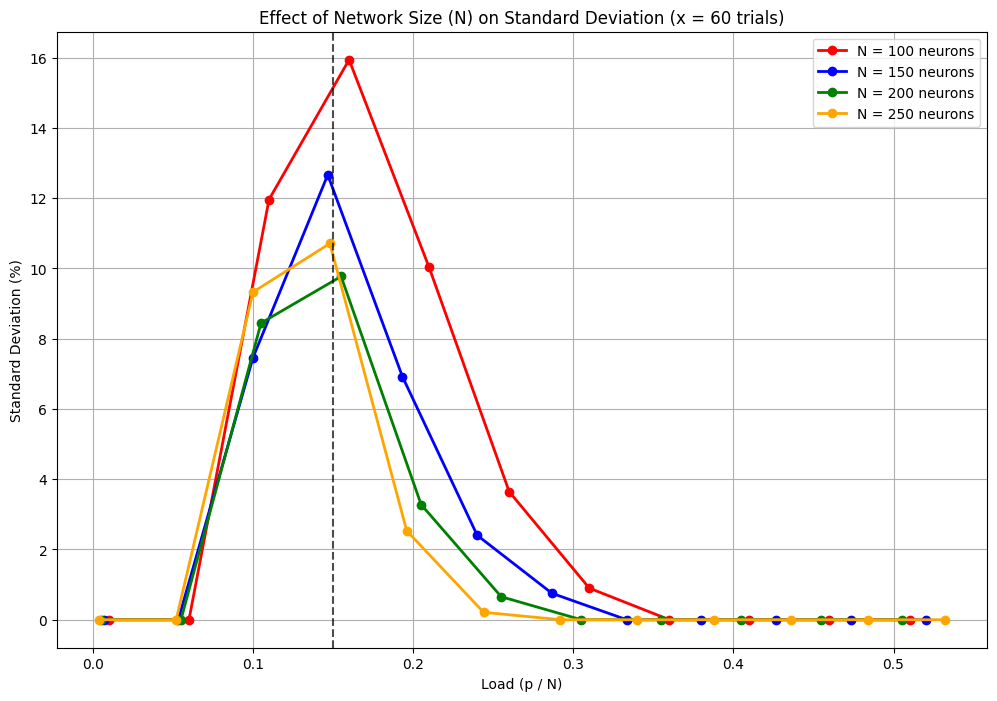


=== SUMMARY STATISTICS ===

N = 100 neurons:
  x = 50 trials: Max std dev = 15.93% at load = 0.160
  x = 55 trials: Max std dev = 15.02% at load = 0.160
  x = 60 trials: Max std dev = 15.94% at load = 0.160
  x = 65 trials: Max std dev = 18.85% at load = 0.160
  x = 70 trials: Max std dev = 15.85% at load = 0.160

N = 150 neurons:
  x = 50 trials: Max std dev = 11.87% at load = 0.147
  x = 55 trials: Max std dev = 13.49% at load = 0.147
  x = 60 trials: Max std dev = 12.67% at load = 0.147
  x = 65 trials: Max std dev = 14.51% at load = 0.147
  x = 70 trials: Max std dev = 14.60% at load = 0.147

N = 200 neurons:
  x = 50 trials: Max std dev = 10.65% at load = 0.105
  x = 55 trials: Max std dev = 9.32% at load = 0.155
  x = 60 trials: Max std dev = 9.77% at load = 0.155
  x = 65 trials: Max std dev = 10.15% at load = 0.155
  x = 70 trials: Max std dev = 9.92% at load = 0.155

N = 250 neurons:
  x = 50 trials: Max std dev = 10.30% at load = 0.148
  x = 55 trials: Max std dev = 9.49% at

In [1]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt

# ADDED: PyTorch accelerated functions
def create_patterns(N, p_num):
    """Create random binary patterns using PyTorch"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    patterns = torch.randint(0, 2, (p_num, N), device=device, dtype=torch.float32)
    patterns = 2 * patterns - 1  # Convert to {-1, 1}
    return patterns

def train(patterns, N, m_diagonal):
    """Train Hopfield network using PyTorch matrix operations"""
    device = patterns.device
    p_num = patterns.shape[0]

    # Compute weight matrix: W = (1/N) * patterns^T * patterns
    W = torch.mm(patterns.t(), patterns) / N

    # Set diagonal elements
    W.fill_diagonal_(m_diagonal)

    return W

def create_noisy_input(pattern, noise_level):
    """Add noise to pattern using PyTorch"""
    device = pattern.device
    if noise_level == 0:
        return pattern.clone()

    noise_mask = torch.rand(pattern.shape, device=device) < noise_level
    noisy_pattern = pattern.clone()
    noisy_pattern[noise_mask] *= -1
    return noisy_pattern

def recall(W, input_pattern, steps=5):
    """Recall pattern using PyTorch"""
    x = input_pattern.clone()

    for _ in range(steps):
        x = torch.sign(torch.mv(W, x))

    return x

def recovered_patterns(recalled_patterns, original_patterns):
    """Count recovered patterns using PyTorch"""
    # Compare patterns element-wise and check if all elements match
    matches = torch.all(recalled_patterns == original_patterns, dim=1)
    return torch.sum(matches).item()

def process_batch_torch(patterns, weights, device):
    """Process all patterns in a batch for efficiency"""
    p_num = patterns.shape[0]

    # Create noisy inputs (no noise in this case)
    noisy_inputs = patterns.clone()  # No noise for now

    # Recall all patterns in batch
    recalled_patterns = torch.zeros_like(patterns)
    for i in range(p_num):
        recalled_patterns[i] = recall(weights, noisy_inputs[i])

    return recalled_patterns

# Test parameters
x_values = [50, 55, 60, 65, 70]  # Different trial counts
N_values = [100, 150, 200, 250]  # Different numbers of neurons
lambda_test = 0  # Just test λ = 0 for simplicity

# Store results for each combination of N and x
results_by_N_x = {}

for N in N_values:
    print(f"\n=== Testing with N = {N} neurons ===")

    # Calculate p values relative to N (keeping same load range)
    p = [i for i in range(1, int(N * 0.55), max(1, int(N * 0.05)))]  # Adjust step size based on N

    results_by_N_x[N] = {}

    for x in x_values:
        start = time.time()
        print(f"--> Testing with x = {x} trials for N = {N}... <--")

        standard_dev = []
        recovered_percent = []

        for p_num in p:
            trial_results = []

            for _ in range(x):
                # Create patterns and train network
                patterns = create_patterns(N, p_num)
                weights = train(patterns, N, lambda_test)

                # Create noisy inputs directly without function calls
                device = patterns.device
                noisy_inputs = patterns.clone()  # Start with original patterns
                noise_mask = torch.rand(patterns.shape, device=device) < 0.1  # 10% noise
                noisy_inputs[noise_mask] *= -1  # Flip bits where noise occurs

                # Recall patterns directly with minimal function calls
                recalled_patterns = torch.zeros_like(patterns)
                for i in range(p_num):
                    x_pattern = noisy_inputs[i].clone()
                    # Direct recall without function call
                    for _ in range(5):  # 5 recall steps
                        x_pattern = torch.sign(torch.mv(weights, x_pattern))
                    recalled_patterns[i] = x_pattern

                # Count recovered patterns directly
                matches = torch.all(recalled_patterns == patterns, dim=1)
                trial_recovery = torch.sum(matches).item()

                # Store the percentage for this trial
                trial_results.append(trial_recovery / p_num * 100)

            # Calculate mean and standard deviation properly
            mean_recovery = np.mean(trial_results)
            recovered_percent.append(mean_recovery)
            standard_dev.append(np.std(trial_results, ddof=1))  # Sample standard deviation

        results_by_N_x[N][x] = {
            'recovery': recovered_percent,
            'std_dev': standard_dev,
            'loads': [p_val / N for p_val in p]
        }

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end = time.time()
        time_elapsed = end - start
        print(f"Time elapsed: {time_elapsed:.2f} seconds")

# Create subplots for each N value
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['red', 'blue', 'green', 'orange', 'purple']

for idx, N in enumerate(N_values):
    ax = axes[idx]

    for i, (x, color) in enumerate(zip(x_values, colors)):
        loads = results_by_N_x[N][x]['loads']
        std_devs = results_by_N_x[N][x]['std_dev']

        ax.plot(loads, std_devs,
                marker='o', linestyle='-', color=color,
                linewidth=2, label=f'x = {x} trials')

    ax.set_xlabel("Load (p / N)")
    ax.set_ylabel("Standard Deviation (%)")
    ax.set_title(f"Effect of Trial Count on Std Dev (N = {N})")
    ax.legend()
    ax.grid(True)
    ax.axvline(x=0.15, color='black', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Also create a combined plot showing the effect of N at a fixed x value
plt.figure(figsize=(12, 8))

# Choose middle x value for comparison
middle_x = x_values[len(x_values)//2]
print(f"\nCreating comparison plot for x = {middle_x} trials")

N_colors = ['red', 'blue', 'green', 'orange']
for i, (N, color) in enumerate(zip(N_values, N_colors)):
    loads = results_by_N_x[N][middle_x]['loads']
    std_devs = results_by_N_x[N][middle_x]['std_dev']

    plt.plot(loads, std_devs,
             marker='o', linestyle='-', color=color,
             linewidth=2, label=f'N = {N} neurons')

plt.xlabel("Load (p / N)")
plt.ylabel("Standard Deviation (%)")
plt.title(f"Effect of Network Size (N) on Standard Deviation (x = {middle_x} trials)")
plt.legend()
plt.grid(True)
plt.axvline(x=0.15, color='black', linestyle='--', alpha=0.7, label='Theoretical Capacity')
plt.show()

# Print summary statistics
print("\n=== SUMMARY STATISTICS ===")
for N in N_values:
    print(f"\nN = {N} neurons:")
    for x in x_values:
        max_std = max(results_by_N_x[N][x]['std_dev'])
        max_load_idx = np.argmax(results_by_N_x[N][x]['std_dev'])
        max_load = results_by_N_x[N][x]['loads'][max_load_idx]
        print(f"  x = {x} trials: Max std dev = {max_std:.2f}% at load = {max_load:.3f}")